# Forberedelsen af data

In [3]:
#Libriaries & Models
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input


from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

In [12]:
# Path setup
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data', 'raw')
output_dir = os.path.join(root_dir, 'out')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Folder '{output_dir}' was created.")
else:
    print(f"Folder '{output_dir}' already exists.")

# Data loading
csv_files = glob.glob(os.path.join(data_dir, 'wind_speed_*.csv'))
dataframes = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dataframes, ignore_index=True)

Folder '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/out' already exists.


Access the datasets

In [16]:
# Find all CSV files in the specified path
csv_files = glob.glob(os.path.join(data_dir, 'wind_speed_*.csv'))

# Read each CSV file into a DataFrame and store in a dictionary
dataframes = {}
for file in csv_files:
    df_name = os.path.basename(file).replace(".csv", "")  # Extract file name without extension
    dataframes[df_name] = pd.read_csv(file)

# Display keys (file names) to ensure everything loaded correctly
print("Loaded datasets:", list(dataframes.keys()))




Loaded datasets: ['wind_speed_19_n', 'wind_speed_13_n', 'wind_speed_11_n', 'wind_speed_15_n', 'wind_speed_17_n']


# Data behandling
Samle alle datasets, så alt data bliver anvendt for modellen

In [17]:
# Læs og kombiner alle datasæt i én DataFrame
dataframes = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dataframes, ignore_index=True)

print("Kombineret datasæts form:", combined_df.shape)

Kombineret datasæts form: (1600005, 21)


In [18]:
def create_time_delayed_features_optimized(df, input_features, time_steps=3):
    """
    Create time-delayed features for a given DataFrame using vectorized operations.
    """
    delayed_df = pd.DataFrame(index=df.index)
    new_input_features = []
    for feature in input_features:
        for t in range(time_steps + 1):
            delayed_df[f"{feature}_t-{t}"] = df[feature].shift(t)
            new_input_features.append(f"{feature}_t-{t}")
    delayed_df.dropna(inplace=True)
    return delayed_df, new_input_features

time_steps = 2

In [19]:
input_features = ['t','beta1', 'beta2', 'beta3', 'Theta', 'omega_r', 'Vwx']
output_features = ['Mz1', 'Mz2', 'Mz3']

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Normalize input features
scaled_data = pd.DataFrame(scaler_X.fit_transform(combined_df[input_features]), columns=input_features)
scaled_data[output_features] = scaler_y.fit_transform(combined_df[output_features])

# Create time-delayed features
delayed_input_df, delayed_input_features = create_time_delayed_features_optimized(scaled_data, input_features, time_steps)

# Trim y for at matche antallet af forsinkede input features
delayed_output_df = scaled_data[output_features].iloc[time_steps:]

# Konverter til numpy arrays for træning
X = delayed_input_df.values
y = delayed_output_df.values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


# Split data i træning (80%) og test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X shape: (1600003, 21)
y shape: (1600003, 3)


RBF modellen:

In [20]:
# RBFN-klasse
class RBFN:
    def __init__(self, input_dim, num_hidden_neurons, output_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.num_hidden_neurons = num_hidden_neurons
        self.output_dim = output_dim
        self.learning_rate = learning_rate

        #init parameters
        self.centroids = np.random.randn(num_hidden_neurons, input_dim)
        self.betas = np.ones(num_hidden_neurons) * 0.5  # Start value
        self.weights = np.random.randn(num_hidden_neurons, output_dim)

    def gaussian_rbf(self, x, center, beta):
        return np.exp(-beta * np.linalg.norm(x - center) ** 2)

    def compute_hidden_layer(self, X):
        """Beregner outputs af hidden laget"""
        G = np.zeros((X.shape[0], self.num_hidden_neurons))
        for i, x in enumerate(X):
            for j, center in enumerate(self.centroids):
                G[i, j] = self.gaussian_rbf(x, center, self.betas[j])
        return G

    def predict(self, X):
        """Forudsig output"""
        G = self.compute_hidden_layer(X)
        return G @ self.weights

    def fit(self, X, y, X_val=None, y_val=None, epochs=10):
        """Træner netværket ved at finde optimale vægte"""
        # Liste til at gemme trænings- og valideringstab
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Beregn hidden lag for træning
            G = self.compute_hidden_layer(X)
            y_pred = G @ self.weights

            # loss (MSE)
            train_loss = mean_squared_error(y, y_pred)
            train_losses.append(train_loss)

            # cal. gradienter
            grad_weights = -2 * G.T @ (y - y_pred) / X.shape[0]
            grad_centroids = np.zeros_like(self.centroids)
            grad_betas = np.zeros_like(self.betas)

            for j in range(self.num_hidden_neurons):
                diff = X - self.centroids[j]
                grad_centroids[j] = -2 * self.betas[j] * ((y - y_pred).T @ (G[:, j][:, None] * diff)).sum(axis=0) / X.shape[0]
                grad_betas[j] = -2 * ((y - y_pred).T @ (G[:, j] * np.linalg.norm(diff, axis=1) ** 2)).sum() / X.shape[0]

            #updates parameters
            self.weights -= self.learning_rate * grad_weights
            self.centroids -= self.learning_rate * grad_centroids
            self.betas -= self.learning_rate * grad_betas

            # Validation loss
            if X_val is not None and y_val is not None:
                G_val = self.compute_hidden_layer(X_val)
                y_val_pred = G_val @ self.weights
                val_loss = mean_squared_error(y_val, y_val_pred)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}")

        return train_losses, val_losses

# Initialisér RBFN med gradient-baseret træning
rbfn = RBFN(input_dim=X_train_split.shape[1], num_hidden_neurons=100, output_dim=y_train_split.shape[1], learning_rate=0.01)

# Træn modellen
train_losses, val_losses = rbfn.fit(X_train_split, y_train_split, X_val=X_val, y_val=y_val, epochs=10)

# Forudsig output
y_pred = rbfn.predict(X_test)

# Beregn MSE for testdata
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error på testdata: {mse}")

#Saving data for plotting
losses_df = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1),
    "Train Loss": train_losses,
    "Validation Loss": val_losses
})

# Gem træningstabellen
losses_df.to_csv(os.path.join(output_dir, "training_validation_losses.csv"), index=False)
print(f"Tabellen over trænings- og valideringstab er gemt i '{output_dir}/training_validation_losses.csv'")

# Gem testforudsigelser og faktiske værdier som CSV

# Gem 't' separat
time_column = combined_df["t"].iloc[time_steps:]
# Match tiden med testdata
time_test = time_column[len(X_train):len(X_train) + len(X_test)]  # Match slicing

print(f"Length of time_test: {len(time_test)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_pred: {len(y_pred)}")

# Debugging: Tjek længder og typer
print(f"Length of time_test: {len(time_test)}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")


predictions_df = pd.DataFrame({
    "Time (t)": time_test,
    "Actual Mz1": y_test[:, 0],
    "Actual Mz2": y_test[:, 1],
    "Actual Mz3": y_test[:, 2],
    "Predicted Mz1": y_pred[:, 0],
    "Predicted Mz2": y_pred[:, 1],
    "Predicted Mz3": y_pred[:, 2]
})

#Gem testforudsigelser
predictions_df.to_csv(os.path.join(output_dir, "test_predictions.csv"), index=False)
print(f"Testforudsigelser og faktiske værdier er gemt i '{output_dir}/test_predictions.csv'")



Epoch 1/10 - Train Loss: 0.1628, Val Loss: 0.1626
Epoch 2/10 - Train Loss: 0.1628, Val Loss: 0.1625
Epoch 3/10 - Train Loss: 0.1627, Val Loss: 0.1624
Epoch 4/10 - Train Loss: 0.1627, Val Loss: 0.1624
Epoch 5/10 - Train Loss: 0.1626, Val Loss: 0.1623


KeyboardInterrupt: 

In [21]:
#Plotting

#train loss
# Indlæs tab
losses_df = pd.read_csv("/content/drive/MyDrive/00_DTU/5. Semester/Deep Learning/Notebook/RBF_Gradient_loss.csv")

# Plot
plt.plot(losses_df["Epoch"], losses_df["Train Loss"], label="Train Loss")
plt.plot(losses_df["Epoch"], losses_df["Validation Loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/00_DTU/5. Semester/Deep Learning/Notebook/RBF_Gradient_loss.csv'

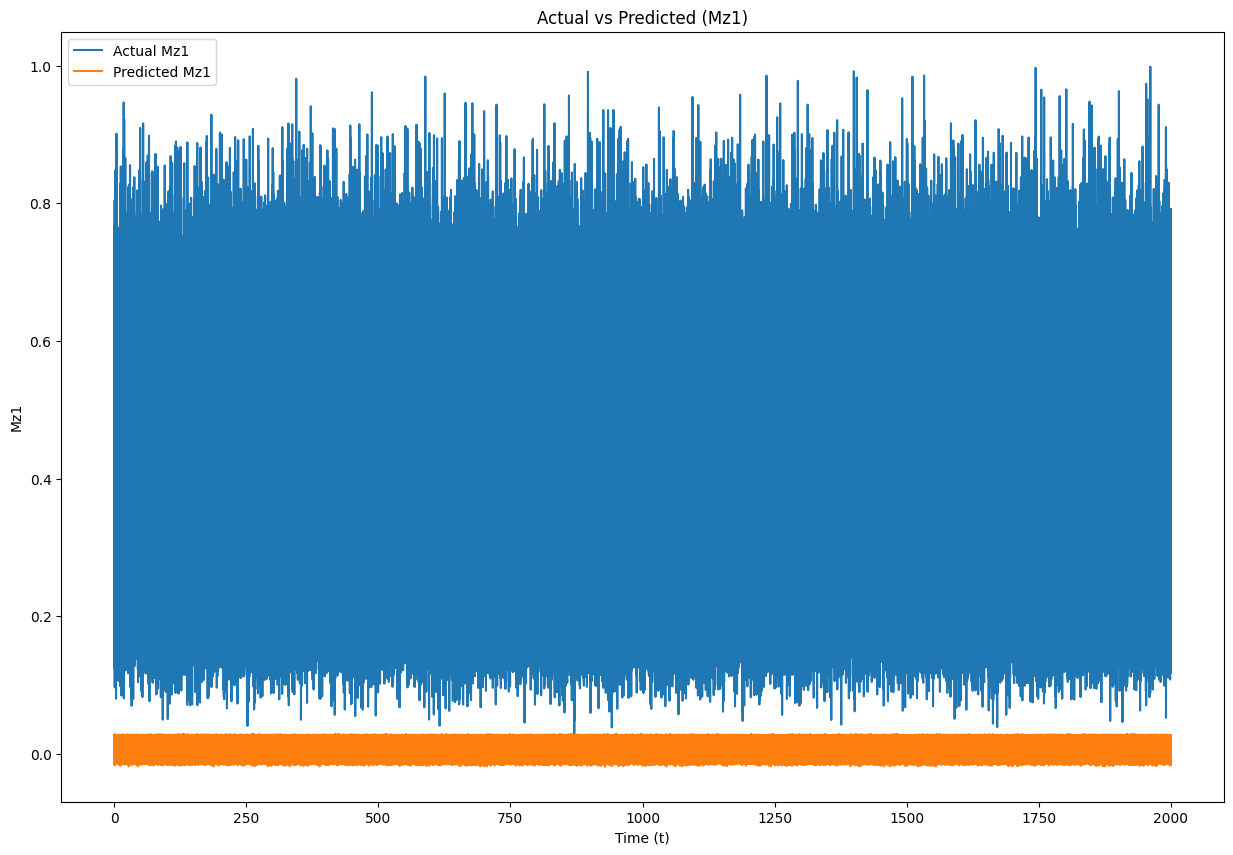

In [ ]:
#predictions
predictions_df = pd.read_csv("/content/drive/MyDrive/00_DTU/5. Semester/Deep Learning/Notebook/RBF_Gradient_results.csv")

# Plot for Mz1
plt.figure(figsize=(15, 10))

plt.plot(predictions_df["Time (t)"], predictions_df["Actual Mz1"], label="Actual Mz1")
plt.plot(predictions_df["Time (t)"], predictions_df["Predicted Mz1"], label="Predicted Mz1")
plt.xlabel("Time (t)")
plt.ylabel("Mz1")
plt.title("Actual vs Predicted (Mz1)")
plt.legend()
plt.show()

In [22]:
#predictions
predictions_df = pd.read_csv("/content/drive/MyDrive/00_DTU/5. Semester/Deep Learning/Notebook/RBF_Gradient_results.csv")

plt.plot(time_test, y_test[:, 0], label="Actual Mz1")
plt.plot(time_test, y_pred[:, 0], label="Predicted Mz1")
plt.xlabel("Time (t)")
plt.ylabel("Mz1")
plt.title("Actual vs Predicted (Mz1)")
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/00_DTU/5. Semester/Deep Learning/Notebook/RBF_Gradient_results.csv'